In [246]:
%cd /content/drive/My Drive/BIO/dataset
# %cd /content/drive/My Drive/BIO

/content/drive/My Drive/BIO/dataset


In [247]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [248]:
from keras.models import Model, load_model
import os

In [249]:
[i for i in os.listdir() if i.endswith("h5")]

['model.h5',
 'model_01.h5',
 'model_425_340_v1.h5',
 'model_625_500_v2.h5',
 'model_625_500_v4.h5',
 'model_625_500_v5.h5']

In [250]:
model = load_model("model_625_500_v5.h5")

In [251]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 625, 500, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 625, 500, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 625, 500, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 625, 500, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 208, 166, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 208, 166, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 208, 166, 64)      1

In [252]:
'''
last_conv_layer_name = "conv2d_24"
classifier_layer_names = [
    "max_pooling2d_9",
    "flatten_1",
    'dense_3',
    'dense_4',
    'dense_5'
]
'''

'\nlast_conv_layer_name = "conv2d_24"\nclassifier_layer_names = [\n    "max_pooling2d_9",\n    "flatten_1",\n    \'dense_3\',\n    \'dense_4\',\n    \'dense_5\'\n]\n'

In [253]:
last_conv_layer_name = "conv2d_5"
classifier_layer_names = [
    "batch_normalization_5",
    "max_pooling2d_2",
    'dropout_2',
    'flatten',
    'dense',
    'batch_normalization_6',
    'dense_1'
]

In [254]:
import os
import glob

In [274]:
#folder = 'train_ii/No Finding_625_500/*'
folder = 'test_ii/Nodule_625_500/*'
img_size=(625, 500)

In [313]:
img = glob.glob(folder)[35]
img

'test_ii/Nodule_625_500/00022470_012.png'

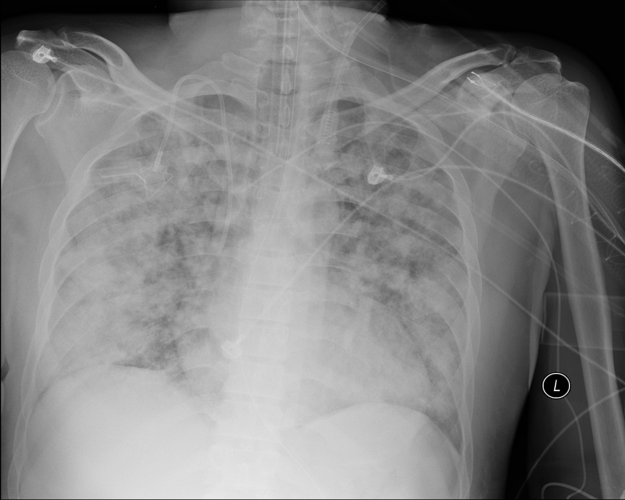

In [314]:
display(Image(img))

In [315]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [316]:
img_ = get_img_array(img, size=img_size)
img_.shape

(1, 625, 500, 3)

In [317]:
# enfs = ['con', 'ede', 'emphy', 'mass', 'no', 'nod', 'pne']
enfs = ['nf', 'nd']

In [318]:
# Print what the top predicted class is
preds = model.predict(img_)
preds
#print("Predicted:", decode_predictions(preds, top=1)[0])

array([[0.30131927, 0.6986807 ]], dtype=float32)

In [319]:
img_

array([[[[  0.,   0.,   0.],
         [  2.,   2.,   2.],
         [  2.,   2.,   2.],
         ...,
         [  2.,   2.,   2.],
         [  2.,   2.,   2.],
         [  2.,   2.,   2.]],

        [[  0.,   0.,   0.],
         [  2.,   2.,   2.],
         [  2.,   2.,   2.],
         ...,
         [  2.,   2.,   2.],
         [  2.,   2.,   2.],
         [  2.,   2.,   2.]],

        [[  0.,   0.,   0.],
         [  2.,   2.,   2.],
         [  2.,   2.,   2.],
         ...,
         [  2.,   2.,   2.],
         [  2.,   2.,   2.],
         [  2.,   2.,   2.]],

        ...,

        [[  8.,   8.,   8.],
         [ 71.,  71.,  71.],
         [ 89.,  89.,  89.],
         ...,
         [132., 132., 132.],
         [138., 138., 138.],
         [134., 134., 134.]],

        [[  8.,   8.,   8.],
         [ 71.,  71.,  71.],
         [ 89.,  89.,  89.],
         ...,
         [132., 132., 132.],
         [138., 138., 138.],
         [134., 134., 134.]],

        [[  4.,   4.,   4.],
       

In [320]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_,
    model, 
    last_conv_layer_name, 
    classifier_layer_names
)
#heatmap
heatmap

array([[0.01678421, 0.03874748, 0.        , ..., 0.        , 0.08579713,
        0.05938022],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.20378317],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.03383242],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.36735803],
       [0.00947253, 0.16885239, 0.        , ..., 0.16596772, 0.4254436 ,
        0.12677272],
       [0.        , 0.33791062, 0.        , ..., 0.02880143, 0.14238992,
        0.03821017]], dtype=float32)

In [321]:
img_.shape

(1, 625, 500, 3)

In [322]:
# imgx.shape

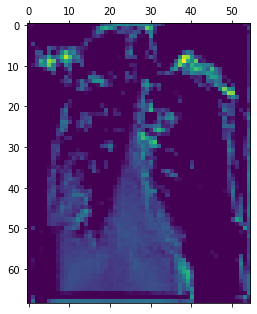

In [323]:
# Display heatmap
plt.matshow(heatmap)
plt.show()

In [324]:
imgx = img_[0]

In [325]:
# We rescale heatmap to a range 0-255
heatmap_ = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap_]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((imgx.shape[1], imgx.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

In [326]:
jet_heatmap.shape

(625, 500, 3)

In [327]:
img_.shape

(1, 625, 500, 3)

In [328]:
# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + imgx
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

In [329]:
img_.shape[1], img_.shape[0]

(625, 1)

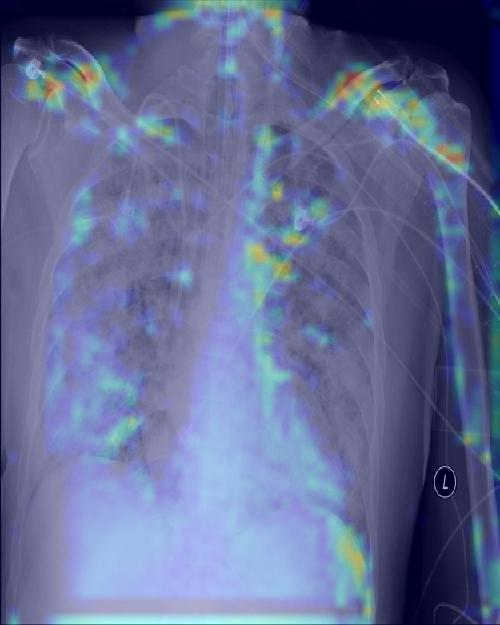

In [330]:
# Save the superimposed image
save_path = "chest_xray.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))